In [1]:
import numpy as np
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy.optimize
import pandas as pd
from IPython.display import Audio
import csv

In [2]:
def get_envelope(t, x, d=1):
    def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
        """
        Input :
        s: 1d-array, data signal from which to extract high and low envelopes
        dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
        split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
        Output :
        lmin,lmax : high/low envelope idx of input signal s
        """

        # locals min
        lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
        # locals max
        lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1

        if split:
            # s_mid is zero if s centered around x-axis or more generally mean of signal
            s_mid = np.mean(s)
            # pre-sorting of locals min based on relative position with respect to s_mid
            lmin = lmin[s[lmin] < s_mid]
            # pre-sorting of local max based on relative position with respect to s_mid
            lmax = lmax[s[lmax] > s_mid]

        # global min of dmin-chunks of locals min
        lmin = lmin[
            [i + np.argmin(s[lmin[i : i + dmin]]) for i in range(0, len(lmin), dmin)]
        ]
        # global max of dmax-chunks of locals max
        lmax = lmax[
            [i + np.argmax(s[lmax[i : i + dmax]]) for i in range(0, len(lmax), dmax)]
        ]

        return lmin, lmax

    _, lmax = hl_envelopes_idx(x, dmax=d)
    lmax = np.interp(t, t[lmax], x[lmax])
    return lmax

def nextpow2(N):
    n = 1
    while n < N:
        n *= 2
    return n

le signal commence à 0.047875 s
niveau de silence: -10.00 dB (0.32 V)
le signal finit à 0.347875


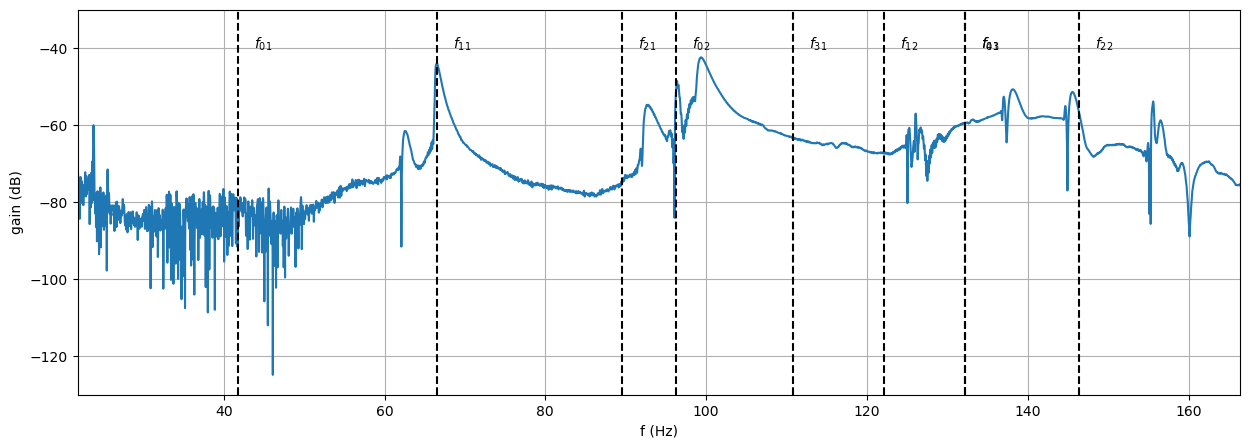

le signal commence à 0.21052083333333332 s
niveau de silence: -48.63 dB (0.00 V)
le signal finit à 0.5105208333333333


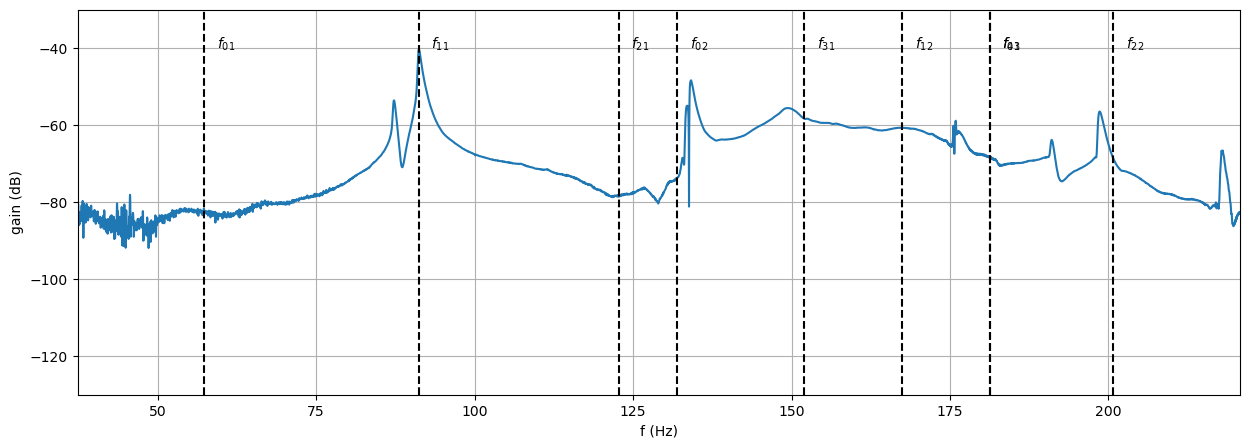

le signal commence à 0.15891666666666668 s
niveau de silence: -49.28 dB (0.00 V)
le signal finit à 0.45891666666666664


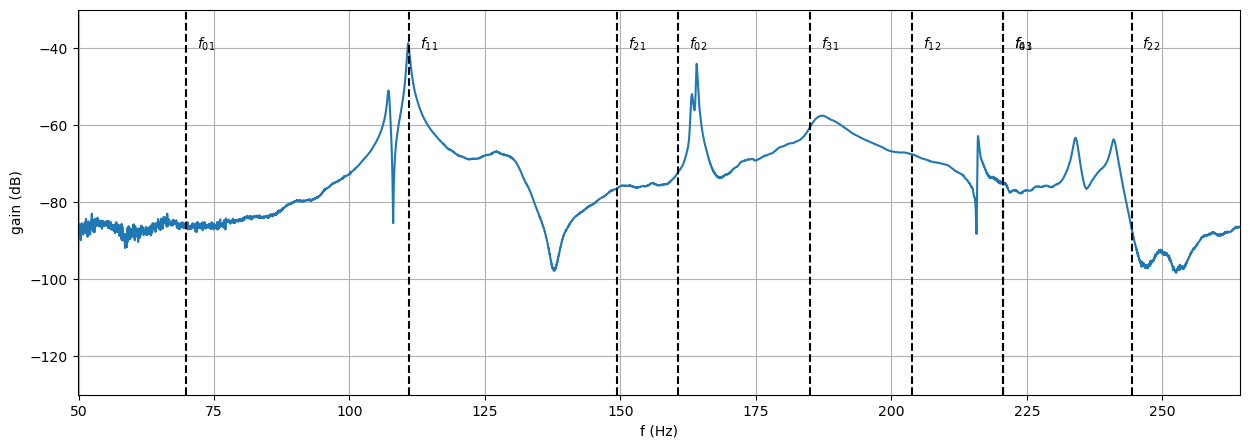

le signal commence à 0.083625 s
niveau de silence: -38.40 dB (0.01 V)
le signal finit à 0.383625


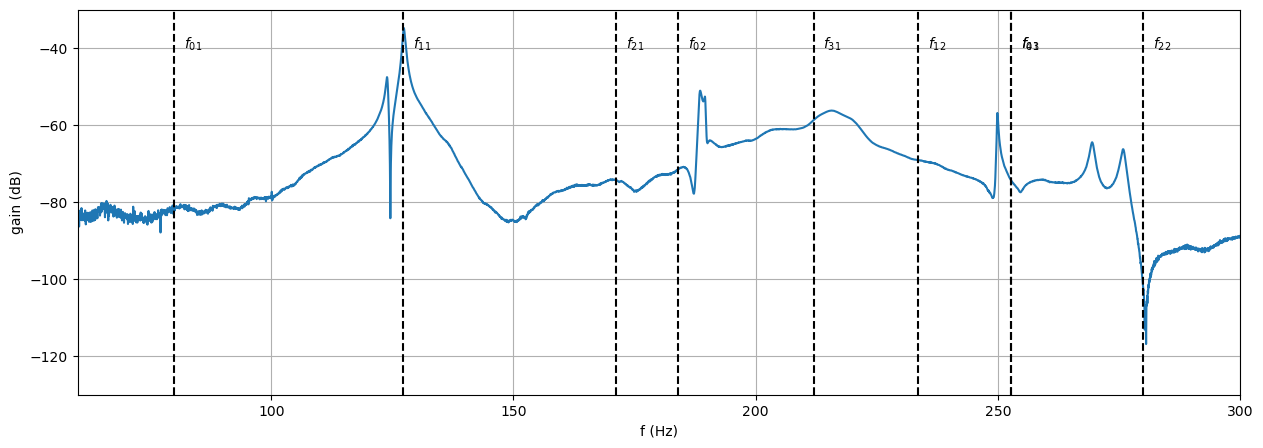

In [6]:
f1s = [66.5, 91.2, 111, 127.2]
variantes = ["a=3R/4", "a=R/2", "a=R/4", "a=0"]
ensembles = ["grave", "migrave", "miaigu", "aigu"]
for f1, ensemble in zip(f1s, ensembles):
    sigs = []

    filenames = [f"timbale-{ensemble}-{i}.wav" for i in range(1,2)]
    for filename in filenames:
        fs, sig = scipy.io.wavfile.read(filename)
        sig = sig.astype(np.float32)
        sig /= np.max(abs(sig))
        t = np.arange(len(sig)) / fs
        env = get_envelope(t, sig)

        MARGE_START_BEFORE = int(0.01 * fs)
        MARGE_START_AFTER = int(0.1 * fs)
        MARGE_SEARCH_END = int(0.2 * fs)
        MARGE_SILENCE = -0.01

        i_silence = np.argmax(abs(sig)) - MARGE_START_BEFORE
        print(f"le signal commence à {i_silence/fs} s")
        silence_level = np.max(abs(sig[:i_silence]))
        print(
            f"niveau de silence: {20*np.log10(silence_level):.2f} dB ({silence_level:.2f} V)"
        )

        t = np.arange(len(sig)) / fs
        i_start = i_silence + MARGE_START_AFTER

        i_searchend = i_start + MARGE_SEARCH_END
        i_end = i_searchend + np.argmax(env[i_searchend:] < silence_level + MARGE_SILENCE)
        print("le signal finit à", i_end / fs)
        
        sig = sig[i_silence:]
        sigs.append(sig)


    l = max(len(s) for s in sigs)
    for i in range(len(sigs)):
        sigs[i] = np.pad(sigs[i], (0, l-len(sigs[i])))
    sigs=np.array(sigs)

    N = 8*nextpow2(l)
    ffts = np.fft.rfft(sigs, N, axis=1) / l
    freq = np.fft.rfftfreq(N, 1/fs)

    beta_mn_fac = np.array([
        [0, 1, 2.30, 3.16], #0n
        [0, 1.59, 2.92, 0], #1n
        [0, 2.14, 3.5, 0], #2n
        [0, 2.65, 0, 0], #3n
        [0, 3.16, 0, 0] # 4n
    ])


    plt.figure(figsize=(15, 5))
    plt.plot(freq, 20 * np.log10(abs(ffts.T)), label=variantes[0])
    for m in range(0,beta_mn_fac.shape[0]):
        for n in range(1,beta_mn_fac.shape[1]):
            f = beta_mn_fac[m, n] * f1 / beta_mn_fac[1,1]
            plt.axvline(f, linestyle="--", color="black")
            plt.annotate(
                "$f_{" + str(m) + str(n) + "}$", (f + 2, -40)
            )
    plt.xlim(f1 / beta_mn_fac[1,1] - 20, 3.5 * f1 / beta_mn_fac[1,1] + 20)
    plt.xlabel("f (Hz)")
    plt.ylim(-130, -30)
    plt.grid()
    plt.ylabel("gain (dB)")
    # plt.legend(loc="upper right")
    # plt.title(ensemble)
    plt.savefig(f"timbale-{ensemble}-spectre.png")
    plt.show()
    plt.close("all")


le signal commence à 0.15891666666666668 s
niveau de silence: -49.28 dB (0.00 V)
le signal finit à 0.45891666666666664
le signal commence à 0.08960416666666667 s
niveau de silence: -4.81 dB (0.57 V)
le signal finit à 0.38960416666666664
le signal commence à 0.1085625 s
niveau de silence: -48.93 dB (0.00 V)
le signal finit à 0.4085625
le signal commence à 0.10622916666666667 s
niveau de silence: -12.43 dB (0.24 V)
le signal finit à 0.40622916666666664


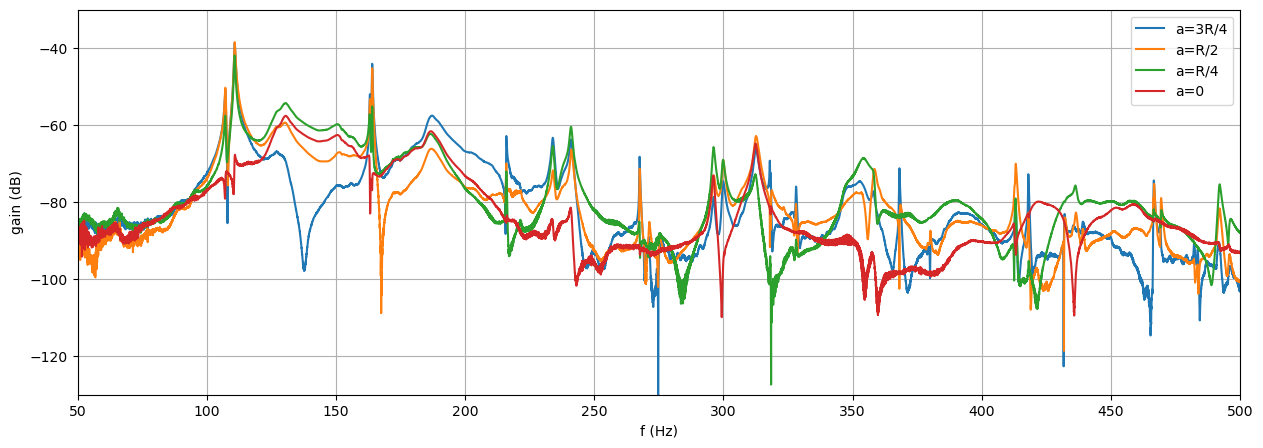

In [14]:
f1s = [66.5, 91.2, 111, 127.2]
variantes = ["a=3R/4", "a=R/2", "a=R/4", "a=0"]
ensembles = ["grave", "migrave", "miaigu", "aigu"]
ensembles = [ensembles[2]]
f1s = [f1s[2]]
for f1, ensemble in zip(f1s, ensembles):
    sigs = []

    filenames = [f"timbale-{ensemble}-{i}.wav" for i in range(1,5)]
    for filename in filenames:
        fs, sig = scipy.io.wavfile.read(filename)
        sig = sig.astype(np.float32)
        sig /= np.max(abs(sig))
        t = np.arange(len(sig)) / fs
        env = get_envelope(t, sig)

        MARGE_START_BEFORE = int(0.01 * fs)
        MARGE_START_AFTER = int(0.1 * fs)
        MARGE_SEARCH_END = int(0.2 * fs)
        MARGE_SILENCE = -0.01

        i_silence = np.argmax(abs(sig)) - MARGE_START_BEFORE
        print(f"le signal commence à {i_silence/fs} s")
        silence_level = np.max(abs(sig[:i_silence]))
        print(
            f"niveau de silence: {20*np.log10(silence_level):.2f} dB ({silence_level:.2f} V)"
        )

        t = np.arange(len(sig)) / fs
        i_start = i_silence + MARGE_START_AFTER

        i_searchend = i_start + MARGE_SEARCH_END
        i_end = i_searchend + np.argmax(env[i_searchend:] < silence_level + MARGE_SILENCE)
        print("le signal finit à", i_end / fs)
        
        sig = sig[i_silence:]
        sigs.append(sig)


    l = max(len(s) for s in sigs)
    for i in range(len(sigs)):
        sigs[i] = np.pad(sigs[i], (0, l-len(sigs[i])))
    sigs=np.array(sigs)

    N = 8*nextpow2(l)
    ffts = np.fft.rfft(sigs, N, axis=1) / l
    freq = np.fft.rfftfreq(N, 1/fs)

    beta_mn_fac = np.array([
        [0, 1, 2.30, 3.16], #0n
        [0, 1.59, 2.92, 0], #1n
        [0, 2.14, 3.5, 0], #2n
        [0, 2.65, 0, 0], #3n
        [0, 3.16, 0, 0] # 4n
    ])


    plt.figure(figsize=(15, 5))
    plt.plot(freq, 20 * np.log10(abs(ffts.T)), label=variantes)
    # for m in range(0,beta_mn_fac.shape[0]):
    #     for n in range(1,beta_mn_fac.shape[1]):
    #         f = beta_mn_fac[m, n] * f1 / beta_mn_fac[1,1]
    #         plt.axvline(f, linestyle="--", color="black")
    #         plt.annotate(
    #             "$f_{" + str(m) + str(n) + "}$", (f + 2, -40)
    #         )
    # plt.xlim(f1 / beta_mn_fac[1,1] - 20, 3.5 * f1 / beta_mn_fac[1,1] + 20)
    plt.xlim(50,500)
    plt.xlabel("f (Hz)")
    plt.ylim(-130, -30)
    plt.grid()
    plt.ylabel("gain (dB)")
plt.legend(loc="upper right")
    # plt.title(ensemble)
plt.savefig(f"timbale-position-frappe.png")
plt.show()
plt.close("all")
